## Six-bar Mechanism Balancing

In [1]:
from BetaShF import ShF
from BetaShM import ShM 
import numpy as np 
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

### Contraints

$-0.16m <= x_{cn},y_{cn} <= 0.16m$

$0.005m <= t_{cn} <= 0.04m$

### Objective Function

In [2]:
def objective_function(s, ShF, ShM): #c is a constant that distributes the weight among the functions.
    c = 0.5
    return c*ShF(s) + c*ShM(s)

### Differential Evolution

In [3]:
# Bounds for each variable
nVar = 5
bounds = []
for i in range(1,nVar*3+1):
    if(i%3==0): bounds.append([0.005,0.04])
    else: bounds.append([-0.16, 0.16])
#print(bounds)


In [4]:
it = 5
n = 100
sols = np.zeros((n, 2))
best, bestSol = 10, None
for i in range(n):
    r = differential_evolution(objective_function, bounds, args=(ShF, ShM), maxiter=it)
    sols[i][0], sols[i][1] = ShF([*r['x']]), ShM([*r['x']])
    if r['fun'] < best:
        best = r['fun']
        bestSol = r

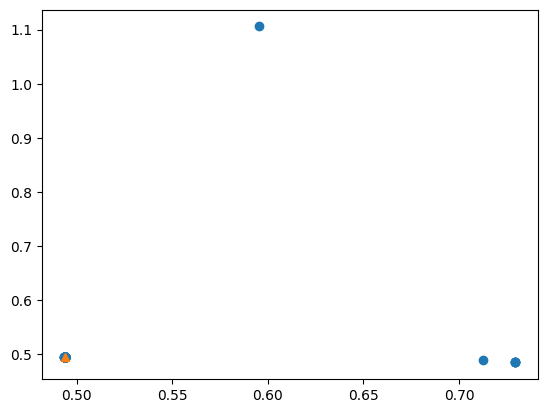

In [5]:
np.savetxt('Solutions.txt', sols, delimiter=', ')   # X is an array

plt.plot(sols[:, 0], sols[:, 1], 'o')
plt.plot(ShF([*bestSol['x']]), ShM([*bestSol['x']]), '^')

In [6]:
np.sqrt(best)

0.7031525142446965

In [7]:
# bestSol
print(bestSol.x)

[-2.53961468e-02 -3.41820385e-02  4.00000000e-02 -8.56203714e-02
 -9.05651136e-03  2.41479977e-02 -5.78430799e-02  6.23291443e-03
  4.00000000e-02  6.61220841e-08 -7.38229472e-07  5.00000000e-03
  3.33419446e-07 -2.92475917e-07  5.00000000e-03]


### Gradient Descent

In [35]:

eps = 1e-5
def Vf(X,ShF,ShM,f):
    n = len(X)
    G = np.zeros((n),float)
    incX = np.zeros((n),float)
    for i in range(n):
        incX[i] = eps
        G[i] = (f(X+incX,ShF, ShM)-f(X,ShF, ShM))/eps
        incX[i] = 0
    return G

def VfTd(X,ShF, ShM,d,f):
    return (f(X+eps*d,ShF, ShM,)-f(X,ShF, ShM,))/eps

def V2f(X,ShF,ShM,f):
    n = len(X)
    H = np.zeros((n,n),float)
    incX = np.zeros((n),float)
    for i in range(n):
        incX[i] = eps
        H[:,i] = (Vf(X+incX,ShF,ShM,f)-Vf(X,ShF,ShM,f))/eps
        incX[i] = 0
    return H

def V2fTd(X,ShF, ShM,d,f):
    return (Vf(X+eps*d,ShF, ShM,f)-Vf(X,ShF, ShM,f))/eps
    
# X = np.array([2,3])
# d = np.array([5,1])

d = -Vf(bestSol.x,ShF,ShM,objective_function)/np.linalg.norm(Vf(bestSol.x, ShF, ShM, objective_function))
print("P_k: ", d)

print('f:',objective_function(bestSol.x,ShF, ShM))
print('Vf:',Vf(bestSol.x, ShF, ShM,objective_function))
print('V2f:',V2f(bestSol.x, ShF, ShM,objective_function))
print('VfTd:',VfTd(bestSol.x, ShF, ShM,d,objective_function))
print('V2fTd:',V2fTd(bestSol.x, ShF, ShM,d,objective_function))

P_k:  [-4.92813128e-03 -7.05055533e-03  3.36407349e-01 -9.96195722e-03
 -1.29254669e-03 -1.42512433e-02 -7.20656772e-03 -9.30608160e-04
  9.41487677e-01 -2.28596025e-04 -1.92329520e-04 -2.45672777e-09
 -2.94297422e-04 -2.59724606e-04 -1.09152950e-09]
f: 0.49442345828863804
Vf: [ 8.69674028e-03  1.24422109e-02 -5.93662623e-01  1.75800014e-02
  2.28097472e-03  2.51493628e-02  1.27175280e-02  1.64225687e-03
 -1.66145611e+00  4.03406514e-04  3.39406520e-04  4.33542091e-09
  5.19350662e-04  4.58339544e-04  1.92623695e-09]
V2f: [[ 1.75190647e+03  1.92670008e+03 -1.21973577e+03 -2.15401562e+03
  -2.27869112e+02  2.57315160e+03  2.96181729e+02 -1.84135243e+02
  -1.70436477e+02 -2.09221529e-02 -1.76031412e-02  3.33066907e-06
   1.02751141e-02  9.06386077e-03 -3.33066907e-06]
 [ 1.92670008e+03  2.51079286e+03 -1.48565161e+03 -2.63780944e+03
  -3.32283171e+02  3.15757714e+03 -3.02893244e+02 -3.08153548e+02
   1.08397697e+02 -2.25636176e-02 -1.89787075e-02  5.55111512e-06
   8.21565038e-05  7.6605

In [75]:
def gradient_descent(x,d, Vf, VfTd, V2f, V2fTd):
    a_k = 0.01
    max_iter = 3
    k=0
    while(k < max_iter and np.linalg.norm(Vf(x, ShF, ShM,objective_function)) > eps ):
        print("#---->",k)
        # Calculate step size a_k
        a_k = (-VfTd(x,ShF, ShM,d,objective_function) * d ) / V2f(x,ShF, ShM,objective_function) * d # P = d
        # one = -VfTd(x,ShF, ShM,d,objective_function)*d
        # two = d*V2f(x,ShF, ShM,objective_function)
        # if( (two == 0).any() == False):
        #     a_k = one/two
       
        # Calculate the direction P_k
        d = -Vf(x,ShF,ShM,objective_function)/np.linalg.norm(Vf(x, ShF, ShM, objective_function))
        x = x + a_k*d
        k+=1
        print("a_k: ",a_k)
        # break
    return x

In [76]:
gradient_descent(bestSol.x,d, Vf, VfTd, V2f, V2fTd)

#----> 0


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()